In [15]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from barney_functions import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import optuna
from optuna.integration import TFKerasPruningCallback
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


### Audio Load by Barney

In [2]:
train_images = np.load('mels_train.npz')['data']
train_y = np.load('mels_train_labels.npz',allow_pickle=True)['data']

val_images = np.load('val_inaug.npz')['data']
val_y = np.load('val_inaug_labels.npz',allow_pickle=True)['data']

test_images = np.load('test_inaug.npz')['data']
test_y = np.load('test_inaug_labels.npz',allow_pickle=True)['data']

num_classes = len(np.unique(train_y))
print('Number of classes: ', num_classes)

#mels, TEST_images, y, TEST_y = train_test_split(mels, y, test_size=0.2, random_state=42)

Number of classes:  4


In [3]:
print(train_images.shape)
print(train_y.shape)
print(val_images.shape)
print(val_y.shape)
print(test_images.shape)
print(test_y.shape)

(1252, 128, 51)
(1252,)
(75, 128, 51)
(75,)
(100, 128, 51)
(100,)


# CNN

# Optimising

In [4]:
def objective(trial):
    
    n_epochs = 25
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-3)
    optimiser = Adam(learning_rate=learning_rate)
    
    filters_1 = trial.suggest_int("filters_1",low=8,high=30,step=2)
    kernel_1 = trial.suggest_int("kernel_size_1",low=6,high=12,step=2)
    strides_1 = 1
    
    activation_1 = trial.suggest_categorical("activation_1", \
                            ["relu", "tanh", "selu", "elu"])
    
    padding_1 = 'same'
    input_shape = (img_rows, img_cols, 1)
    pool_size_1 = trial.suggest_int("pool_size_1",low=2,high=4,step=1)
    
    filters_2 = trial.suggest_int("filters_2",low=16,high=60,step=2)
    kernel_2 = trial.suggest_int("kernel_size_2",low=4,high=12,step=2)
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = trial.suggest_categorical("activation_2", \
                        ["relu", "tanh", "selu", "elu"])
    pool_size_2 = trial.suggest_int("pool_size_2",low=2,high=4,step=1)
    
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    
    lin_1_n = trial.suggest_int("lin_1_n",low=70,high=126,step=4)
    
    batch_size = 128
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    monitor = "val_categorical_accuracy"
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10)]
        #TFKerasPruningCallback(trial, monitor)]
    
    fitted = model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=n_epochs,
                       verbose=1,
                       validation_data=(X_val, y_val),
                       callbacks=callbacks)
    
    score = fitted.history[monitor][-1]
    
    return score
# changed trials to 50 from 10
# removed pruning but not callbacks

In [5]:
#train_images, val_images, train_labels, val_labels = train_test_split(mels, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, img_rows, img_cols = format_for_CNN(train_images, val_images, train_y, val_y)
#check_class_complete_gen(train_y, val_y, train_y)

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-06-13 18:44:18,001] A new study created in memory with name: no-name-8cfb822c-8adb-4637-8403-047a29ee1f91
2022-06-13 18:44:18.011893: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 18:44:18.012184: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 31s 25ms/sample - loss: 1.3729 - categorical_accuracy: 0.4153 - val_loss: 1.0504 - val_categorical_accuracy: 0.4267
Epoch 2/25
1252/1252 [==============================] - 31s 25ms/sample - loss: 0.8174 - categorical_accuracy: 0.6414 - val_loss: 0.8948 - val_categorical_accuracy: 0.5867
Epoch 3/25
1252/1252 [==============================] - 30s 24ms/sample - loss: 0.6663 - categorical_accuracy: 0.7029 - val_loss: 0.6750 - val_categorical_accuracy: 0.6933
Epoch 4/25
1252/1252 [==============================] - 30s 24ms/sample - loss: 0.5405 - categorical_accuracy: 0.7636 - val_loss: 0.6483 - val_categorical_accuracy: 0.6800
Epoch 5/25
1252/1252 [==============================] - 31s 24ms/sample - loss: 0.4666 - categorical_accuracy: 0.8003 - val_loss: 0.5898 - val_categorical_accuracy: 0.7200
Epoch 6/25
1252/1252 [==============================] - 30s 24ms/sample - loss: 0.4192 - categ

[I 2022-06-13 18:56:52,826] Trial 0 finished with value: 0.9066666960716248 and parameters: {'learning_rate': 0.0008517314244586904, 'filters_1': 18, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 46, 'kernel_size_2': 10, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.4239207158681981, 'lin_1_n': 126}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 1.0830 - categorical_accuracy: 0.5040 - val_loss: 1.1300 - val_categorical_accuracy: 0.4000
Epoch 2/25
1252/1252 [==============================] - 8s 7ms/sample - loss: 0.7075 - categorical_accuracy: 0.6925 - val_loss: 1.1231 - val_categorical_accuracy: 0.4667
Epoch 3/25
1252/1252 [==============================] - 8s 7ms/sample - loss: 0.5956 - categorical_accuracy: 0.7508 - val_loss: 1.1620 - val_categorical_accuracy: 0.4133
Epoch 4/25
1252/1252 [==============================] - 8s 7ms/sample - loss: 0.5314 - categorical_accuracy: 0.7636 - val_loss: 1.0235 - val_categorical_accuracy: 0.5333
Epoch 5/25
1252/1252 [==============================] - 8s 7ms/sample - loss: 0.4717 - categorical_accuracy: 0.8043 - val_loss: 0.8506 - val_categorical_accuracy: 0.5600
Epoch 6/25
1252/1252 [==============================] - 8s 7ms/sample - loss: 0.4557 - categorical_accur

[I 2022-06-13 18:58:59,270] Trial 1 finished with value: 0.47999998927116394 and parameters: {'learning_rate': 0.00040910246962377444, 'filters_1': 10, 'kernel_size_1': 8, 'activation_1': 'tanh', 'pool_size_1': 4, 'filters_2': 36, 'kernel_size_2': 10, 'activation_2': 'tanh', 'pool_size_2': 2, 'dropout_rate': 0.508618615228599, 'lin_1_n': 90}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 19s 15ms/sample - loss: 1.2260 - categorical_accuracy: 0.4273 - val_loss: 1.1754 - val_categorical_accuracy: 0.5600
Epoch 2/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.9872 - categorical_accuracy: 0.5735 - val_loss: 1.0204 - val_categorical_accuracy: 0.6133
Epoch 3/25
1252/1252 [==============================] - 18s 15ms/sample - loss: 0.8313 - categorical_accuracy: 0.6262 - val_loss: 1.0803 - val_categorical_accuracy: 0.4933
Epoch 4/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.7492 - categorical_accuracy: 0.6949 - val_loss: 1.0814 - val_categorical_accuracy: 0.4400
Epoch 5/25
1252/1252 [==============================] - 19s 15ms/sample - loss: 0.6792 - categorical_accuracy: 0.7157 - val_loss: 0.8964 - val_categorical_accuracy: 0.5867
Epoch 6/25
1252/1252 [==============================] - 18s 15ms/sample - loss: 0.6415 - categ

[I 2022-06-13 19:06:38,256] Trial 2 finished with value: 0.6266666650772095 and parameters: {'learning_rate': 0.0001842150009827903, 'filters_1': 30, 'kernel_size_1': 6, 'activation_1': 'elu', 'pool_size_1': 4, 'filters_2': 40, 'kernel_size_2': 12, 'activation_2': 'tanh', 'pool_size_2': 4, 'dropout_rate': 0.40018385391598943, 'lin_1_n': 110}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 1.1371 - categorical_accuracy: 0.4784 - val_loss: 0.7778 - val_categorical_accuracy: 0.7867
Epoch 2/25
1252/1252 [==============================] - 19s 15ms/sample - loss: 0.8016 - categorical_accuracy: 0.6366 - val_loss: 0.9431 - val_categorical_accuracy: 0.5733
Epoch 3/25
1252/1252 [==============================] - 19s 16ms/sample - loss: 0.7093 - categorical_accuracy: 0.6821 - val_loss: 0.7121 - val_categorical_accuracy: 0.7067
Epoch 4/25
1252/1252 [==============================] - 19s 15ms/sample - loss: 0.5978 - categorical_accuracy: 0.7444 - val_loss: 0.8717 - val_categorical_accuracy: 0.5867
Epoch 5/25
1252/1252 [==============================] - 19s 15ms/sample - loss: 0.5156 - categorical_accuracy: 0.7748 - val_loss: 0.7710 - val_categorical_accuracy: 0.6533
Epoch 6/25
1252/1252 [==============================] - 19s 15ms/sample - loss: 0.4778 - categ

[I 2022-06-13 19:10:49,317] Trial 3 finished with value: 0.6000000238418579 and parameters: {'learning_rate': 0.0005874605648846408, 'filters_1': 30, 'kernel_size_1': 12, 'activation_1': 'tanh', 'pool_size_1': 3, 'filters_2': 40, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.38444910852722103, 'lin_1_n': 126}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 1.1179 - categorical_accuracy: 0.4856 - val_loss: 0.7666 - val_categorical_accuracy: 0.6933
Epoch 2/25
1252/1252 [==============================] - 9s 8ms/sample - loss: 0.7312 - categorical_accuracy: 0.6901 - val_loss: 1.0030 - val_categorical_accuracy: 0.5467
Epoch 3/25
1252/1252 [==============================] - 9s 8ms/sample - loss: 0.5854 - categorical_accuracy: 0.7404 - val_loss: 0.7124 - val_categorical_accuracy: 0.7333
Epoch 4/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.5233 - categorical_accuracy: 0.7708 - val_loss: 0.7823 - val_categorical_accuracy: 0.6533
Epoch 5/25
1252/1252 [==============================] - 9s 8ms/sample - loss: 0.4207 - categorical_accuracy: 0.8291 - val_loss: 0.7011 - val_categorical_accuracy: 0.7067
Epoch 6/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.3401 - categorical_accu

[I 2022-06-13 19:14:48,007] Trial 4 finished with value: 0.8666666746139526 and parameters: {'learning_rate': 0.0009905648701936695, 'filters_1': 16, 'kernel_size_1': 10, 'activation_1': 'relu', 'pool_size_1': 3, 'filters_2': 40, 'kernel_size_2': 8, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.3385903772062954, 'lin_1_n': 82}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 12s 9ms/sample - loss: 1.1443 - categorical_accuracy: 0.4800 - val_loss: 0.7402 - val_categorical_accuracy: 0.8933
Epoch 2/25
1252/1252 [==============================] - 11s 8ms/sample - loss: 0.7434 - categorical_accuracy: 0.6653 - val_loss: 0.8207 - val_categorical_accuracy: 0.6667
Epoch 3/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 0.6108 - categorical_accuracy: 0.7188 - val_loss: 0.8268 - val_categorical_accuracy: 0.6133
Epoch 4/25
1252/1252 [==============================] - 11s 8ms/sample - loss: 0.4950 - categorical_accuracy: 0.7819 - val_loss: 0.6693 - val_categorical_accuracy: 0.7467
Epoch 5/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 0.4221 - categorical_accuracy: 0.8099 - val_loss: 0.7334 - val_categorical_accuracy: 0.6400
Epoch 6/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 0.3810 - categorical

[I 2022-06-13 19:19:18,059] Trial 5 finished with value: 0.8799999952316284 and parameters: {'learning_rate': 0.0007953423372325831, 'filters_1': 14, 'kernel_size_1': 8, 'activation_1': 'relu', 'pool_size_1': 3, 'filters_2': 42, 'kernel_size_2': 8, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.3017375144959047, 'lin_1_n': 102}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 22s 17ms/sample - loss: 1.0916 - categorical_accuracy: 0.4872 - val_loss: 0.8302 - val_categorical_accuracy: 0.8000
Epoch 2/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.7866 - categorical_accuracy: 0.6526 - val_loss: 0.8841 - val_categorical_accuracy: 0.5867
Epoch 3/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.6992 - categorical_accuracy: 0.7133 - val_loss: 0.6678 - val_categorical_accuracy: 0.6933
Epoch 4/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.6959 - categorical_accuracy: 0.6981 - val_loss: 0.5446 - val_categorical_accuracy: 0.7867
Epoch 5/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.6492 - categorical_accuracy: 0.7396 - val_loss: 0.5080 - val_categorical_accuracy: 0.7467
Epoch 6/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.6530 - categ

[I 2022-06-13 19:27:34,262] Trial 6 finished with value: 0.746666669845581 and parameters: {'learning_rate': 0.0005137233659844222, 'filters_1': 24, 'kernel_size_1': 12, 'activation_1': 'tanh', 'pool_size_1': 2, 'filters_2': 28, 'kernel_size_2': 8, 'activation_2': 'elu', 'pool_size_2': 3, 'dropout_rate': 0.4955035213096438, 'lin_1_n': 106}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 1.1822 - categorical_accuracy: 0.4609 - val_loss: 0.9516 - val_categorical_accuracy: 0.7867
Epoch 2/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.8546 - categorical_accuracy: 0.6150 - val_loss: 0.8202 - val_categorical_accuracy: 0.6667
Epoch 3/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.7037 - categorical_accuracy: 0.6941 - val_loss: 0.8154 - val_categorical_accuracy: 0.6533
Epoch 4/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.5905 - categorical_accuracy: 0.7460 - val_loss: 0.7653 - val_categorical_accuracy: 0.6933
Epoch 5/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.5242 - categorical_accuracy: 0.7875 - val_loss: 0.5352 - val_categorical_accuracy: 0.8133
Epoch 6/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.4742 - categ

[I 2022-06-13 19:33:19,675] Trial 7 finished with value: 0.800000011920929 and parameters: {'learning_rate': 0.0005577687141098359, 'filters_1': 22, 'kernel_size_1': 12, 'activation_1': 'relu', 'pool_size_1': 4, 'filters_2': 26, 'kernel_size_2': 8, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.5357421318776419, 'lin_1_n': 70}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 1.3423 - categorical_accuracy: 0.3466 - val_loss: 1.0517 - val_categorical_accuracy: 0.7067
Epoch 2/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 1.2507 - categorical_accuracy: 0.4265 - val_loss: 1.1030 - val_categorical_accuracy: 0.7067
Epoch 3/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 1.1567 - categorical_accuracy: 0.5144 - val_loss: 1.0479 - val_categorical_accuracy: 0.7467
Epoch 4/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 1.0506 - categorical_accuracy: 0.5407 - val_loss: 0.9490 - val_categorical_accuracy: 0.8133
Epoch 5/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.9516 - categorical_accuracy: 0.5639 - val_loss: 0.9077 - val_categorical_accuracy: 0.7067
Epoch 6/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.8620 - categ

[I 2022-06-13 19:39:18,281] Trial 8 finished with value: 0.7333333492279053 and parameters: {'learning_rate': 0.00015485426235461997, 'filters_1': 18, 'kernel_size_1': 12, 'activation_1': 'elu', 'pool_size_1': 3, 'filters_2': 28, 'kernel_size_2': 4, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.5608225698045319, 'lin_1_n': 74}. Best is trial 0 with value: 0.9066666960716248.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 22s 17ms/sample - loss: 1.1122 - categorical_accuracy: 0.5128 - val_loss: 0.8252 - val_categorical_accuracy: 0.6800
Epoch 2/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.6254 - categorical_accuracy: 0.7165 - val_loss: 1.0488 - val_categorical_accuracy: 0.5333
Epoch 3/25
1252/1252 [==============================] - 21s 16ms/sample - loss: 0.5797 - categorical_accuracy: 0.7356 - val_loss: 0.7441 - val_categorical_accuracy: 0.6533
Epoch 4/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.4760 - categorical_accuracy: 0.8011 - val_loss: 0.7371 - val_categorical_accuracy: 0.6533
Epoch 5/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.3900 - categorical_accuracy: 0.8251 - val_loss: 0.4648 - val_categorical_accuracy: 0.7600
Epoch 6/25
1252/1252 [==============================] - 21s 16ms/sample - loss: 0.3363 - categ

[I 2022-06-13 19:47:56,478] Trial 9 finished with value: 0.9599999785423279 and parameters: {'learning_rate': 0.0008351125917121206, 'filters_1': 30, 'kernel_size_1': 8, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 26, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.4041500318305392, 'lin_1_n': 94}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 36s 29ms/sample - loss: 1.6467 - categorical_accuracy: 0.4808 - val_loss: 0.8839 - val_categorical_accuracy: 0.6533
Epoch 2/25
1252/1252 [==============================] - 36s 29ms/sample - loss: 0.7788 - categorical_accuracy: 0.6430 - val_loss: 0.8991 - val_categorical_accuracy: 0.5600
Epoch 3/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.6121 - categorical_accuracy: 0.7452 - val_loss: 0.7707 - val_categorical_accuracy: 0.6667
Epoch 4/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.4905 - categorical_accuracy: 0.7907 - val_loss: 0.6003 - val_categorical_accuracy: 0.7867
Epoch 5/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.4667 - categorical_accuracy: 0.7995 - val_loss: 1.0372 - val_categorical_accuracy: 0.5067
Epoch 6/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.3791 - categ

[I 2022-06-13 19:56:12,546] Trial 10 finished with value: 0.5066666603088379 and parameters: {'learning_rate': 0.0007539175365026138, 'filters_1': 26, 'kernel_size_1': 6, 'activation_1': 'selu', 'pool_size_1': 2, 'filters_2': 60, 'kernel_size_2': 6, 'activation_2': 'selu', 'pool_size_2': 2, 'dropout_rate': 0.4678344555538482, 'lin_1_n': 90}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 34s 28ms/sample - loss: 1.0478 - categorical_accuracy: 0.5088 - val_loss: 0.7296 - val_categorical_accuracy: 0.7067
Epoch 2/25
1252/1252 [==============================] - 33s 27ms/sample - loss: 0.7531 - categorical_accuracy: 0.6558 - val_loss: 0.9327 - val_categorical_accuracy: 0.5067
Epoch 3/25
1252/1252 [==============================] - 33s 26ms/sample - loss: 0.6348 - categorical_accuracy: 0.7204 - val_loss: 0.8622 - val_categorical_accuracy: 0.6267
Epoch 4/25
1252/1252 [==============================] - 33s 27ms/sample - loss: 0.5542 - categorical_accuracy: 0.7532 - val_loss: 0.4655 - val_categorical_accuracy: 0.8667
Epoch 5/25
1252/1252 [==============================] - 33s 26ms/sample - loss: 0.4716 - categorical_accuracy: 0.7979 - val_loss: 0.4972 - val_categorical_accuracy: 0.7867
Epoch 6/25
1252/1252 [==============================] - 33s 27ms/sample - loss: 0.4273 - categ

[I 2022-06-13 20:10:05,083] Trial 11 finished with value: 0.8933333158493042 and parameters: {'learning_rate': 0.0009883538369619303, 'filters_1': 20, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 16, 'kernel_size_2': 12, 'activation_2': 'tanh', 'pool_size_2': 4, 'dropout_rate': 0.4081419292692097, 'lin_1_n': 126}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 26s 21ms/sample - loss: 1.2187 - categorical_accuracy: 0.5224 - val_loss: 0.6604 - val_categorical_accuracy: 0.8933
Epoch 2/25
1252/1252 [==============================] - 25s 20ms/sample - loss: 0.9259 - categorical_accuracy: 0.6198 - val_loss: 0.7604 - val_categorical_accuracy: 0.5600
Epoch 3/25
1252/1252 [==============================] - 24s 20ms/sample - loss: 0.9435 - categorical_accuracy: 0.6262 - val_loss: 0.8461 - val_categorical_accuracy: 0.5067
Epoch 4/25
1252/1252 [==============================] - 25s 20ms/sample - loss: 0.7959 - categorical_accuracy: 0.7069 - val_loss: 0.9367 - val_categorical_accuracy: 0.5467
Epoch 5/25
1252/1252 [==============================] - 25s 20ms/sample - loss: 0.7941 - categorical_accuracy: 0.7412 - val_loss: 0.7979 - val_categorical_accuracy: 0.5867
Epoch 6/25
1252/1252 [==============================] - 25s 20ms/sample - loss: 0.7139 - categ

[I 2022-06-13 20:14:36,715] Trial 12 finished with value: 0.7200000286102295 and parameters: {'learning_rate': 0.0008195851825534368, 'filters_1': 12, 'kernel_size_1': 10, 'activation_1': 'selu', 'pool_size_1': 2, 'filters_2': 52, 'kernel_size_2': 10, 'activation_2': 'elu', 'pool_size_2': 3, 'dropout_rate': 0.4378822311360824, 'lin_1_n': 114}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 1.0521 - categorical_accuracy: 0.5256 - val_loss: 1.0524 - val_categorical_accuracy: 0.4000
Epoch 2/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.6718 - categorical_accuracy: 0.6917 - val_loss: 0.6992 - val_categorical_accuracy: 0.7333
Epoch 3/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.5570 - categorical_accuracy: 0.7668 - val_loss: 0.6636 - val_categorical_accuracy: 0.7733
Epoch 4/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.4628 - categorical_accuracy: 0.8155 - val_loss: 0.8304 - val_categorical_accuracy: 0.5467
Epoch 5/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.4115 - categorical_accuracy: 0.8355 - val_loss: 0.6081 - val_categorical_accuracy: 0.7333
Epoch 6/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.3572 - categorical_accur

[I 2022-06-13 20:17:51,509] Trial 13 finished with value: 0.8666666746139526 and parameters: {'learning_rate': 0.0007278056595750337, 'filters_1': 8, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 48, 'kernel_size_2': 6, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.5972387544054096, 'lin_1_n': 94}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 33s 27ms/sample - loss: 1.6537 - categorical_accuracy: 0.3922 - val_loss: 1.0266 - val_categorical_accuracy: 0.4933
Epoch 2/25
1252/1252 [==============================] - 33s 26ms/sample - loss: 0.8932 - categorical_accuracy: 0.5679 - val_loss: 0.8591 - val_categorical_accuracy: 0.6267
Epoch 3/25
1252/1252 [==============================] - 32s 26ms/sample - loss: 0.7021 - categorical_accuracy: 0.6877 - val_loss: 0.9027 - val_categorical_accuracy: 0.5200
Epoch 4/25
1252/1252 [==============================] - 33s 26ms/sample - loss: 0.6083 - categorical_accuracy: 0.7444 - val_loss: 0.7270 - val_categorical_accuracy: 0.7067
Epoch 5/25
1252/1252 [==============================] - 32s 26ms/sample - loss: 0.5413 - categorical_accuracy: 0.7732 - val_loss: 0.6420 - val_categorical_accuracy: 0.7200
Epoch 6/25
1252/1252 [==============================] - 33s 26ms/sample - loss: 0.4700 - categ

[I 2022-06-13 20:31:31,773] Trial 14 finished with value: 0.8266666531562805 and parameters: {'learning_rate': 0.0009151516298934627, 'filters_1': 26, 'kernel_size_1': 6, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 16, 'kernel_size_2': 10, 'activation_2': 'tanh', 'pool_size_2': 2, 'dropout_rate': 0.35982031510935353, 'lin_1_n': 118}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 18s 15ms/sample - loss: 1.0501 - categorical_accuracy: 0.5375 - val_loss: 0.6458 - val_categorical_accuracy: 0.8933
Epoch 2/25
1252/1252 [==============================] - 17s 14ms/sample - loss: 0.7386 - categorical_accuracy: 0.6789 - val_loss: 0.6394 - val_categorical_accuracy: 0.7600
Epoch 3/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.6207 - categorical_accuracy: 0.7236 - val_loss: 0.6043 - val_categorical_accuracy: 0.7333
Epoch 4/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.5227 - categorical_accuracy: 0.7772 - val_loss: 0.6770 - val_categorical_accuracy: 0.7067
Epoch 5/25
1252/1252 [==============================] - 17s 14ms/sample - loss: 0.4598 - categorical_accuracy: 0.8227 - val_loss: 0.4935 - val_categorical_accuracy: 0.8400
Epoch 6/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.4332 - categ

[I 2022-06-13 20:38:53,416] Trial 15 finished with value: 0.9200000166893005 and parameters: {'learning_rate': 0.0006851260214324064, 'filters_1': 18, 'kernel_size_1': 10, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 32, 'kernel_size_2': 6, 'activation_2': 'tanh', 'pool_size_2': 4, 'dropout_rate': 0.43583893410623176, 'lin_1_n': 98}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 1.1799 - categorical_accuracy: 0.4760 - val_loss: 0.9803 - val_categorical_accuracy: 0.6667
Epoch 2/25
1252/1252 [==============================] - 13s 10ms/sample - loss: 0.8346 - categorical_accuracy: 0.6302 - val_loss: 1.0373 - val_categorical_accuracy: 0.5333
Epoch 3/25
1252/1252 [==============================] - 13s 10ms/sample - loss: 0.7264 - categorical_accuracy: 0.6749 - val_loss: 0.8281 - val_categorical_accuracy: 0.7067
Epoch 4/25
1252/1252 [==============================] - 13s 10ms/sample - loss: 0.6274 - categorical_accuracy: 0.7252 - val_loss: 0.7658 - val_categorical_accuracy: 0.7200
Epoch 5/25
1252/1252 [==============================] - 13s 10ms/sample - loss: 0.5288 - categorical_accuracy: 0.7764 - val_loss: 0.6550 - val_categorical_accuracy: 0.7733
Epoch 6/25
1252/1252 [==============================] - 13s 10ms/sample - loss: 0.4648 - categ

[I 2022-06-13 20:44:11,105] Trial 16 finished with value: 0.8933333158493042 and parameters: {'learning_rate': 0.000644333620264834, 'filters_1': 22, 'kernel_size_1': 10, 'activation_1': 'relu', 'pool_size_1': 3, 'filters_2': 22, 'kernel_size_2': 6, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.46074471877079604, 'lin_1_n': 98}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 16s 12ms/sample - loss: 1.0849 - categorical_accuracy: 0.5168 - val_loss: 0.7799 - val_categorical_accuracy: 0.9067
Epoch 2/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.8326 - categorical_accuracy: 0.6278 - val_loss: 0.5977 - val_categorical_accuracy: 0.8533
Epoch 3/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.6973 - categorical_accuracy: 0.6893 - val_loss: 0.6792 - val_categorical_accuracy: 0.7333
Epoch 4/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.5922 - categorical_accuracy: 0.7452 - val_loss: 0.6168 - val_categorical_accuracy: 0.7600
Epoch 5/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.5493 - categorical_accuracy: 0.7468 - val_loss: 0.7396 - val_categorical_accuracy: 0.7067
Epoch 6/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.5145 - categ

[I 2022-06-13 20:50:28,079] Trial 17 finished with value: 0.7866666913032532 and parameters: {'learning_rate': 0.0003804853864658716, 'filters_1': 14, 'kernel_size_1': 10, 'activation_1': 'selu', 'pool_size_1': 2, 'filters_2': 34, 'kernel_size_2': 4, 'activation_2': 'elu', 'pool_size_2': 4, 'dropout_rate': 0.36459369854514273, 'lin_1_n': 82}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 23s 19ms/sample - loss: 1.2038 - categorical_accuracy: 0.4561 - val_loss: 0.8231 - val_categorical_accuracy: 0.8800
Epoch 2/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.8064 - categorical_accuracy: 0.6621 - val_loss: 0.7306 - val_categorical_accuracy: 0.7067
Epoch 3/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.6653 - categorical_accuracy: 0.7236 - val_loss: 0.8551 - val_categorical_accuracy: 0.5467
Epoch 4/25
1252/1252 [==============================] - 23s 18ms/sample - loss: 0.5846 - categorical_accuracy: 0.7300 - val_loss: 0.7847 - val_categorical_accuracy: 0.6000
Epoch 5/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.4835 - categorical_accuracy: 0.7907 - val_loss: 0.7152 - val_categorical_accuracy: 0.6933
Epoch 6/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.4320 - categ

[I 2022-06-13 20:59:48,604] Trial 18 finished with value: 0.8933333158493042 and parameters: {'learning_rate': 0.0006741921690980147, 'filters_1': 28, 'kernel_size_1': 10, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 32, 'kernel_size_2': 6, 'activation_2': 'tanh', 'pool_size_2': 4, 'dropout_rate': 0.4812090608737344, 'lin_1_n': 86}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 1.2258 - categorical_accuracy: 0.4537 - val_loss: 1.0089 - val_categorical_accuracy: 0.7600
Epoch 2/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 0.9530 - categorical_accuracy: 0.5631 - val_loss: 0.8704 - val_categorical_accuracy: 0.6533
Epoch 3/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.8415 - categorical_accuracy: 0.6158 - val_loss: 0.8464 - val_categorical_accuracy: 0.7333
Epoch 4/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.7534 - categorical_accuracy: 0.6693 - val_loss: 0.8093 - val_categorical_accuracy: 0.6267
Epoch 5/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.6987 - categorical_accuracy: 0.6893 - val_loss: 0.9077 - val_categorical_accuracy: 0.6000
Epoch 6/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.6497 - categorical

[I 2022-06-13 21:04:09,525] Trial 19 finished with value: 0.7733333110809326 and parameters: {'learning_rate': 0.00047152504062843484, 'filters_1': 20, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 3, 'filters_2': 22, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.43953488816830905, 'lin_1_n': 98}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 1.0764 - categorical_accuracy: 0.4928 - val_loss: 0.8199 - val_categorical_accuracy: 0.6267
Epoch 2/25
1252/1252 [==============================] - 13s 11ms/sample - loss: 0.7337 - categorical_accuracy: 0.6725 - val_loss: 0.5483 - val_categorical_accuracy: 0.8400
Epoch 3/25
1252/1252 [==============================] - 13s 11ms/sample - loss: 0.6008 - categorical_accuracy: 0.7388 - val_loss: 0.6265 - val_categorical_accuracy: 0.7867
Epoch 4/25
1252/1252 [==============================] - 13s 11ms/sample - loss: 0.5124 - categorical_accuracy: 0.7907 - val_loss: 0.5848 - val_categorical_accuracy: 0.7867
Epoch 5/25
1252/1252 [==============================] - 13s 11ms/sample - loss: 0.4566 - categorical_accuracy: 0.7995 - val_loss: 0.4871 - val_categorical_accuracy: 0.7867
Epoch 6/25
1252/1252 [==============================] - 13s 11ms/sample - loss: 0.3916 - categ

[I 2022-06-13 21:09:44,406] Trial 20 finished with value: 0.9066666960716248 and parameters: {'learning_rate': 0.0006589593725773019, 'filters_1': 24, 'kernel_size_1': 10, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 22, 'kernel_size_2': 6, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.31843361230900213, 'lin_1_n': 106}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 28s 23ms/sample - loss: 1.2777 - categorical_accuracy: 0.4449 - val_loss: 0.9653 - val_categorical_accuracy: 0.5200
Epoch 2/25
1252/1252 [==============================] - 27s 22ms/sample - loss: 0.7930 - categorical_accuracy: 0.6398 - val_loss: 0.8753 - val_categorical_accuracy: 0.5333
Epoch 3/25
1252/1252 [==============================] - 28s 22ms/sample - loss: 0.6182 - categorical_accuracy: 0.7428 - val_loss: 0.7013 - val_categorical_accuracy: 0.6800
Epoch 4/25
1252/1252 [==============================] - 28s 22ms/sample - loss: 0.5284 - categorical_accuracy: 0.7612 - val_loss: 0.7875 - val_categorical_accuracy: 0.6133
Epoch 5/25
1252/1252 [==============================] - 28s 22ms/sample - loss: 0.4335 - categorical_accuracy: 0.8075 - val_loss: 0.5515 - val_categorical_accuracy: 0.7733
Epoch 6/25
1252/1252 [==============================] - 28s 22ms/sample - loss: 0.3638 - categ

[I 2022-06-13 21:21:19,540] Trial 21 finished with value: 0.8799999952316284 and parameters: {'learning_rate': 0.0008499499367606966, 'filters_1': 18, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 48, 'kernel_size_2': 10, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.41443263221484994, 'lin_1_n': 118}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 1.1444 - categorical_accuracy: 0.4720 - val_loss: 0.6441 - val_categorical_accuracy: 0.7867
Epoch 2/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.6440 - categorical_accuracy: 0.7196 - val_loss: 0.8072 - val_categorical_accuracy: 0.6000
Epoch 3/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.5410 - categorical_accuracy: 0.7540 - val_loss: 0.4788 - val_categorical_accuracy: 0.8400
Epoch 4/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.4454 - categorical_accuracy: 0.7979 - val_loss: 0.5711 - val_categorical_accuracy: 0.7467
Epoch 5/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.3381 - categorical_accuracy: 0.8730 - val_loss: 0.7982 - val_categorical_accuracy: 0.5600
Epoch 6/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.2895 - categorical_accu

[I 2022-06-13 21:25:01,378] Trial 22 finished with value: 0.8666666746139526 and parameters: {'learning_rate': 0.0008601439314065907, 'filters_1': 16, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 46, 'kernel_size_2': 4, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.4321267634743782, 'lin_1_n': 102}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 1.3812 - categorical_accuracy: 0.4329 - val_loss: 0.9595 - val_categorical_accuracy: 0.5333
Epoch 2/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.7839 - categorical_accuracy: 0.6470 - val_loss: 0.8683 - val_categorical_accuracy: 0.6000
Epoch 3/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.6312 - categorical_accuracy: 0.7236 - val_loss: 0.7686 - val_categorical_accuracy: 0.6800
Epoch 4/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.5178 - categorical_accuracy: 0.7971 - val_loss: 0.6548 - val_categorical_accuracy: 0.7333
Epoch 5/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.4497 - categorical_accuracy: 0.8147 - val_loss: 0.6651 - val_categorical_accuracy: 0.7200
Epoch 6/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.3853 - categorical_accu

[I 2022-06-13 21:28:47,952] Trial 23 finished with value: 0.8666666746139526 and parameters: {'learning_rate': 0.0009255319783674131, 'filters_1': 16, 'kernel_size_1': 6, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 56, 'kernel_size_2': 6, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.38372808256405627, 'lin_1_n': 94}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 22s 17ms/sample - loss: 1.1285 - categorical_accuracy: 0.4657 - val_loss: 0.9904 - val_categorical_accuracy: 0.5467
Epoch 2/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.6990 - categorical_accuracy: 0.6917 - val_loss: 0.8996 - val_categorical_accuracy: 0.6267
Epoch 3/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.5785 - categorical_accuracy: 0.7548 - val_loss: 0.7858 - val_categorical_accuracy: 0.6133
Epoch 4/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.4788 - categorical_accuracy: 0.8067 - val_loss: 0.8044 - val_categorical_accuracy: 0.6000
Epoch 5/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.4139 - categorical_accuracy: 0.8291 - val_loss: 0.6131 - val_categorical_accuracy: 0.6800
Epoch 6/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 0.3602 - categ

[I 2022-06-13 21:37:35,620] Trial 24 finished with value: 0.8933333158493042 and parameters: {'learning_rate': 0.0007432964471775515, 'filters_1': 22, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 3, 'filters_2': 32, 'kernel_size_2': 12, 'activation_2': 'tanh', 'pool_size_2': 2, 'dropout_rate': 0.42591957918563167, 'lin_1_n': 110}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 1.0939 - categorical_accuracy: 0.5056 - val_loss: 0.8238 - val_categorical_accuracy: 0.7200
Epoch 2/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.6612 - categorical_accuracy: 0.7181 - val_loss: 0.8246 - val_categorical_accuracy: 0.6000
Epoch 3/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.5411 - categorical_accuracy: 0.7588 - val_loss: 0.8412 - val_categorical_accuracy: 0.6133
Epoch 4/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.4328 - categorical_accuracy: 0.8131 - val_loss: 0.6420 - val_categorical_accuracy: 0.7067
Epoch 5/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.3523 - categorical_accuracy: 0.8642 - val_loss: 0.6543 - val_categorical_accuracy: 0.7067
Epoch 6/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.2943 - categ

[I 2022-06-13 21:45:43,298] Trial 25 finished with value: 0.9200000166893005 and parameters: {'learning_rate': 0.0008985449286507134, 'filters_1': 18, 'kernel_size_1': 10, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 44, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.45319315483113504, 'lin_1_n': 94}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 1.0666 - categorical_accuracy: 0.4936 - val_loss: 0.9495 - val_categorical_accuracy: 0.5600
Epoch 2/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.7555 - categorical_accuracy: 0.6733 - val_loss: 0.7519 - val_categorical_accuracy: 0.6800
Epoch 3/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.6379 - categorical_accuracy: 0.7252 - val_loss: 1.0981 - val_categorical_accuracy: 0.4667
Epoch 4/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.5562 - categorical_accuracy: 0.7636 - val_loss: 0.8889 - val_categorical_accuracy: 0.5600
Epoch 5/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.4410 - categorical_accuracy: 0.8187 - val_loss: 0.8546 - val_categorical_accuracy: 0.5733
Epoch 6/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.3866 - categ

[I 2022-06-13 21:51:30,824] Trial 26 finished with value: 0.8133333325386047 and parameters: {'learning_rate': 0.0009167614726563176, 'filters_1': 14, 'kernel_size_1': 10, 'activation_1': 'tanh', 'pool_size_1': 2, 'filters_2': 30, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.5203458554886219, 'lin_1_n': 82}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 23s 18ms/sample - loss: 1.2502 - categorical_accuracy: 0.4665 - val_loss: 1.0817 - val_categorical_accuracy: 0.5467
Epoch 2/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.7963 - categorical_accuracy: 0.6573 - val_loss: 0.9023 - val_categorical_accuracy: 0.6267
Epoch 3/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.6625 - categorical_accuracy: 0.6997 - val_loss: 0.6972 - val_categorical_accuracy: 0.7200
Epoch 4/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.5861 - categorical_accuracy: 0.7540 - val_loss: 0.6616 - val_categorical_accuracy: 0.7600
Epoch 5/25
1252/1252 [==============================] - 23s 18ms/sample - loss: 0.4614 - categorical_accuracy: 0.8107 - val_loss: 0.6681 - val_categorical_accuracy: 0.7200
Epoch 6/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.3791 - categ

[I 2022-06-13 22:00:25,586] Trial 27 finished with value: 0.7200000286102295 and parameters: {'learning_rate': 0.0007031199785635586, 'filters_1': 20, 'kernel_size_1': 10, 'activation_1': 'selu', 'pool_size_1': 2, 'filters_2': 36, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.45666554404698534, 'lin_1_n': 90}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 1.1938 - categorical_accuracy: 0.4505 - val_loss: 1.1404 - val_categorical_accuracy: 0.4267
Epoch 2/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.8640 - categorical_accuracy: 0.6270 - val_loss: 0.9852 - val_categorical_accuracy: 0.4667
Epoch 3/25
1252/1252 [==============================] - 9s 8ms/sample - loss: 0.7356 - categorical_accuracy: 0.6829 - val_loss: 0.7863 - val_categorical_accuracy: 0.7067
Epoch 4/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.6594 - categorical_accuracy: 0.7228 - val_loss: 0.9010 - val_categorical_accuracy: 0.6133
Epoch 5/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.6047 - categorical_accuracy: 0.7332 - val_loss: 0.8364 - val_categorical_accuracy: 0.5867
Epoch 6/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 0.5497 - categorical_accu

[I 2022-06-13 22:04:22,677] Trial 28 finished with value: 0.8133333325386047 and parameters: {'learning_rate': 0.0006058429941783233, 'filters_1': 12, 'kernel_size_1': 10, 'activation_1': 'elu', 'pool_size_1': 3, 'filters_2': 24, 'kernel_size_2': 6, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.4773055786243872, 'lin_1_n': 94}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 18s 15ms/sample - loss: 1.2044 - categorical_accuracy: 0.4824 - val_loss: 0.7639 - val_categorical_accuracy: 0.7467
Epoch 2/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.7068 - categorical_accuracy: 0.6941 - val_loss: 0.4811 - val_categorical_accuracy: 0.8800
Epoch 3/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.5833 - categorical_accuracy: 0.7284 - val_loss: 0.6110 - val_categorical_accuracy: 0.7600
Epoch 4/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.4962 - categorical_accuracy: 0.7931 - val_loss: 0.5054 - val_categorical_accuracy: 0.8000
Epoch 5/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.4290 - categorical_accuracy: 0.8211 - val_loss: 0.4988 - val_categorical_accuracy: 0.8000
Epoch 6/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.3890 - categ

[I 2022-06-13 22:11:52,237] Trial 29 finished with value: 0.9066666960716248 and parameters: {'learning_rate': 0.0007732861951939793, 'filters_1': 24, 'kernel_size_1': 12, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 42, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.38826577305449916, 'lin_1_n': 102}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 23s 18ms/sample - loss: 1.3982 - categorical_accuracy: 0.4097 - val_loss: 1.0399 - val_categorical_accuracy: 0.6800
Epoch 2/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.7806 - categorical_accuracy: 0.6709 - val_loss: 0.7879 - val_categorical_accuracy: 0.6133
Epoch 3/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.5647 - categorical_accuracy: 0.7572 - val_loss: 0.8189 - val_categorical_accuracy: 0.5467
Epoch 4/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.4455 - categorical_accuracy: 0.8019 - val_loss: 0.7439 - val_categorical_accuracy: 0.5867
Epoch 5/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.3298 - categorical_accuracy: 0.8682 - val_loss: 0.4687 - val_categorical_accuracy: 0.8133
Epoch 6/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.2652 - categ

[I 2022-06-13 22:18:53,435] Trial 30 finished with value: 0.8799999952316284 and parameters: {'learning_rate': 0.0008888465725741389, 'filters_1': 18, 'kernel_size_1': 10, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 46, 'kernel_size_2': 6, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.356666280727171, 'lin_1_n': 86}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 23s 19ms/sample - loss: 1.0197 - categorical_accuracy: 0.5256 - val_loss: 0.6339 - val_categorical_accuracy: 0.7867
Epoch 2/25
1252/1252 [==============================] - 23s 18ms/sample - loss: 0.7152 - categorical_accuracy: 0.6805 - val_loss: 0.5513 - val_categorical_accuracy: 0.8400
Epoch 3/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.5800 - categorical_accuracy: 0.7436 - val_loss: 0.5666 - val_categorical_accuracy: 0.8000
Epoch 4/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.4700 - categorical_accuracy: 0.8107 - val_loss: 0.5196 - val_categorical_accuracy: 0.7733
Epoch 5/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.3790 - categorical_accuracy: 0.8498 - val_loss: 0.5045 - val_categorical_accuracy: 0.8000
Epoch 6/25
1252/1252 [==============================] - 22s 18ms/sample - loss: 0.3274 - categ

[I 2022-06-13 22:27:52,136] Trial 31 finished with value: 0.8799999952316284 and parameters: {'learning_rate': 0.0006437362772531222, 'filters_1': 28, 'kernel_size_1': 10, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 22, 'kernel_size_2': 6, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.339997391554138, 'lin_1_n': 98}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 19s 15ms/sample - loss: 1.2465 - categorical_accuracy: 0.4577 - val_loss: 0.9818 - val_categorical_accuracy: 0.5600
Epoch 2/25
1252/1252 [==============================] - 18s 15ms/sample - loss: 0.8209 - categorical_accuracy: 0.6310 - val_loss: 0.9457 - val_categorical_accuracy: 0.5867
Epoch 3/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.6951 - categorical_accuracy: 0.7220 - val_loss: 0.8896 - val_categorical_accuracy: 0.6667
Epoch 4/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.6193 - categorical_accuracy: 0.7452 - val_loss: 0.7517 - val_categorical_accuracy: 0.6933
Epoch 5/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.5690 - categorical_accuracy: 0.7827 - val_loss: 0.6796 - val_categorical_accuracy: 0.7333
Epoch 6/25
1252/1252 [==============================] - 18s 14ms/sample - loss: 0.5120 - categ

[I 2022-06-13 22:34:51,485] Trial 32 finished with value: 0.8133333325386047 and parameters: {'learning_rate': 0.0007913672906604604, 'filters_1': 24, 'kernel_size_1': 12, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 44, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.39288486612426465, 'lin_1_n': 102}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 1.1229 - categorical_accuracy: 0.4688 - val_loss: 1.1339 - val_categorical_accuracy: 0.4133
Epoch 2/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.8211 - categorical_accuracy: 0.6238 - val_loss: 0.7811 - val_categorical_accuracy: 0.6933
Epoch 3/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.6605 - categorical_accuracy: 0.7196 - val_loss: 0.7195 - val_categorical_accuracy: 0.7733
Epoch 4/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.5369 - categorical_accuracy: 0.7859 - val_loss: 0.6527 - val_categorical_accuracy: 0.7600
Epoch 5/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.4471 - categorical_accuracy: 0.8299 - val_loss: 0.6624 - val_categorical_accuracy: 0.7600
Epoch 6/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.3708 - categorical_accur

[I 2022-06-13 22:37:56,126] Trial 33 finished with value: 0.8666666746139526 and parameters: {'learning_rate': 0.0009522807127844584, 'filters_1': 16, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 4, 'filters_2': 36, 'kernel_size_2': 10, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.42096876713490916, 'lin_1_n': 90}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 38s 30ms/sample - loss: 1.1080 - categorical_accuracy: 0.5112 - val_loss: 0.9847 - val_categorical_accuracy: 0.4533
Epoch 2/25
1252/1252 [==============================] - 37s 29ms/sample - loss: 0.8108 - categorical_accuracy: 0.6414 - val_loss: 0.9484 - val_categorical_accuracy: 0.5067
Epoch 3/25
1252/1252 [==============================] - 37s 29ms/sample - loss: 0.6922 - categorical_accuracy: 0.6989 - val_loss: 0.8374 - val_categorical_accuracy: 0.6400
Epoch 4/25
1252/1252 [==============================] - 37s 29ms/sample - loss: 0.6116 - categorical_accuracy: 0.7340 - val_loss: 0.6937 - val_categorical_accuracy: 0.6400
Epoch 5/25
1252/1252 [==============================] - 37s 30ms/sample - loss: 0.5337 - categorical_accuracy: 0.7756 - val_loss: 0.8096 - val_categorical_accuracy: 0.5600
Epoch 6/25
1252/1252 [==============================] - 37s 30ms/sample - loss: 0.4936 - categ

[I 2022-06-13 22:53:19,375] Trial 34 finished with value: 0.7333333492279053 and parameters: {'learning_rate': 0.00031825511486850526, 'filters_1': 18, 'kernel_size_1': 6, 'activation_1': 'tanh', 'pool_size_1': 2, 'filters_2': 52, 'kernel_size_2': 12, 'activation_2': 'elu', 'pool_size_2': 3, 'dropout_rate': 0.4949164327133061, 'lin_1_n': 106}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 16s 12ms/sample - loss: 1.1176 - categorical_accuracy: 0.4657 - val_loss: 0.9499 - val_categorical_accuracy: 0.6000
Epoch 2/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.7726 - categorical_accuracy: 0.6526 - val_loss: 0.9380 - val_categorical_accuracy: 0.5867
Epoch 3/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.6206 - categorical_accuracy: 0.7332 - val_loss: 0.7982 - val_categorical_accuracy: 0.6400
Epoch 4/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.5296 - categorical_accuracy: 0.7612 - val_loss: 0.8581 - val_categorical_accuracy: 0.5600
Epoch 5/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.4659 - categorical_accuracy: 0.8019 - val_loss: 0.6983 - val_categorical_accuracy: 0.6533
Epoch 6/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.3907 - categ

[I 2022-06-13 22:59:27,438] Trial 35 finished with value: 0.9066666960716248 and parameters: {'learning_rate': 0.00082872881834735, 'filters_1': 20, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 3, 'filters_2': 38, 'kernel_size_2': 8, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.45587447085328553, 'lin_1_n': 78}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 1.1695 - categorical_accuracy: 0.5024 - val_loss: 0.8988 - val_categorical_accuracy: 0.6133
Epoch 2/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.7011 - categorical_accuracy: 0.7077 - val_loss: 1.0363 - val_categorical_accuracy: 0.5467
Epoch 3/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.5190 - categorical_accuracy: 0.7827 - val_loss: 0.7803 - val_categorical_accuracy: 0.6000
Epoch 4/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 0.4087 - categorical_accuracy: 0.8331 - val_loss: 0.5300 - val_categorical_accuracy: 0.8000
Epoch 5/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.3517 - categorical_accuracy: 0.8642 - val_loss: 0.7479 - val_categorical_accuracy: 0.5867
Epoch 6/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.2806 - categorical

[I 2022-06-13 23:03:39,243] Trial 36 finished with value: 0.9066666960716248 and parameters: {'learning_rate': 0.0008762809167780488, 'filters_1': 12, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 40, 'kernel_size_2': 4, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.4037553681587742, 'lin_1_n': 122}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 1.0878 - categorical_accuracy: 0.4960 - val_loss: 1.0106 - val_categorical_accuracy: 0.5067
Epoch 2/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.8231 - categorical_accuracy: 0.6486 - val_loss: 1.1598 - val_categorical_accuracy: 0.4533
Epoch 3/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.6731 - categorical_accuracy: 0.6949 - val_loss: 0.7700 - val_categorical_accuracy: 0.6800
Epoch 4/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.5418 - categorical_accuracy: 0.7660 - val_loss: 0.6998 - val_categorical_accuracy: 0.6933
Epoch 5/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.4713 - categorical_accuracy: 0.8035 - val_loss: 1.0785 - val_categorical_accuracy: 0.5067
Epoch 6/25
1252/1252 [==============================] - 7s 6ms/sample - loss: 0.4127 - categorical_accur

[I 2022-06-13 23:06:22,887] Trial 37 finished with value: 0.8666666746139526 and parameters: {'learning_rate': 0.0009603457805080335, 'filters_1': 16, 'kernel_size_1': 8, 'activation_1': 'tanh', 'pool_size_1': 3, 'filters_2': 52, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.4433300518812424, 'lin_1_n': 110}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 27s 21ms/sample - loss: 1.1869 - categorical_accuracy: 0.4752 - val_loss: 0.9411 - val_categorical_accuracy: 0.6000
Epoch 2/25
1252/1252 [==============================] - 26s 21ms/sample - loss: 0.7657 - categorical_accuracy: 0.6669 - val_loss: 0.7843 - val_categorical_accuracy: 0.6267
Epoch 3/25
1252/1252 [==============================] - 26s 21ms/sample - loss: 0.6308 - categorical_accuracy: 0.7101 - val_loss: 0.9089 - val_categorical_accuracy: 0.5467
Epoch 4/25
1252/1252 [==============================] - 26s 21ms/sample - loss: 0.5366 - categorical_accuracy: 0.7724 - val_loss: 0.6722 - val_categorical_accuracy: 0.6800
Epoch 5/25
1252/1252 [==============================] - 26s 21ms/sample - loss: 0.4844 - categorical_accuracy: 0.7939 - val_loss: 0.5767 - val_categorical_accuracy: 0.7200
Epoch 6/25
1252/1252 [==============================] - 26s 21ms/sample - loss: 0.4463 - categ

[I 2022-06-13 23:17:14,254] Trial 38 finished with value: 0.8933333158493042 and parameters: {'learning_rate': 0.0007057696487448758, 'filters_1': 22, 'kernel_size_1': 10, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 38, 'kernel_size_2': 8, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.4976696401671423, 'lin_1_n': 86}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 1.1098 - categorical_accuracy: 0.4832 - val_loss: 0.9839 - val_categorical_accuracy: 0.6533
Epoch 2/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.7965 - categorical_accuracy: 0.6374 - val_loss: 0.7652 - val_categorical_accuracy: 0.7200
Epoch 3/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.6681 - categorical_accuracy: 0.7061 - val_loss: 0.8152 - val_categorical_accuracy: 0.6000
Epoch 4/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.5628 - categorical_accuracy: 0.7604 - val_loss: 0.7611 - val_categorical_accuracy: 0.6400
Epoch 5/25
1252/1252 [==============================] - 13s 11ms/sample - loss: 0.5063 - categorical_accuracy: 0.7843 - val_loss: 0.7021 - val_categorical_accuracy: 0.6800
Epoch 6/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.4783 - categ

[I 2022-06-13 23:22:53,681] Trial 39 finished with value: 0.6800000071525574 and parameters: {'learning_rate': 0.0008000967096992406, 'filters_1': 30, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 4, 'filters_2': 28, 'kernel_size_2': 8, 'activation_2': 'elu', 'pool_size_2': 2, 'dropout_rate': 0.378400151211438, 'lin_1_n': 94}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 16s 13ms/sample - loss: 1.0582 - categorical_accuracy: 0.5383 - val_loss: 1.1178 - val_categorical_accuracy: 0.3467
Epoch 2/25
1252/1252 [==============================] - 16s 12ms/sample - loss: 0.7276 - categorical_accuracy: 0.6669 - val_loss: 0.9316 - val_categorical_accuracy: 0.4933
Epoch 3/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.5921 - categorical_accuracy: 0.7380 - val_loss: 0.8498 - val_categorical_accuracy: 0.5333
Epoch 4/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.4769 - categorical_accuracy: 0.7875 - val_loss: 0.7415 - val_categorical_accuracy: 0.6000
Epoch 5/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.3884 - categorical_accuracy: 0.8490 - val_loss: 0.9145 - val_categorical_accuracy: 0.5467
Epoch 6/25
1252/1252 [==============================] - 15s 12ms/sample - loss: 0.3245 - categ

[I 2022-06-13 23:29:21,264] Trial 40 finished with value: 0.800000011920929 and parameters: {'learning_rate': 0.0005974127505714756, 'filters_1': 18, 'kernel_size_1': 6, 'activation_1': 'relu', 'pool_size_1': 3, 'filters_2': 42, 'kernel_size_2': 10, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.42030644342444856, 'lin_1_n': 98}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 5s 4ms/sample - loss: 1.5604 - categorical_accuracy: 0.4193 - val_loss: 1.2271 - val_categorical_accuracy: 0.3200
Epoch 2/25
1252/1252 [==============================] - 4s 4ms/sample - loss: 0.9312 - categorical_accuracy: 0.6134 - val_loss: 0.8099 - val_categorical_accuracy: 0.7467
Epoch 3/25
1252/1252 [==============================] - 4s 4ms/sample - loss: 0.7301 - categorical_accuracy: 0.6741 - val_loss: 0.7082 - val_categorical_accuracy: 0.8533
Epoch 4/25
1252/1252 [==============================] - 5s 4ms/sample - loss: 0.6242 - categorical_accuracy: 0.7428 - val_loss: 0.6650 - val_categorical_accuracy: 0.7733
Epoch 5/25
1252/1252 [==============================] - 4s 4ms/sample - loss: 0.5446 - categorical_accuracy: 0.7716 - val_loss: 0.7038 - val_categorical_accuracy: 0.7200
Epoch 6/25
1252/1252 [==============================] - 4s 4ms/sample - loss: 0.4774 - categorical_accur

[I 2022-06-13 23:31:14,580] Trial 41 finished with value: 0.9066666960716248 and parameters: {'learning_rate': 0.0008740690613019837, 'filters_1': 8, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 40, 'kernel_size_2': 4, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.40103917157903685, 'lin_1_n': 122}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 11s 9ms/sample - loss: 1.0988 - categorical_accuracy: 0.4752 - val_loss: 0.8309 - val_categorical_accuracy: 0.7467
Epoch 2/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.7441 - categorical_accuracy: 0.6797 - val_loss: 0.7588 - val_categorical_accuracy: 0.7067
Epoch 3/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.6151 - categorical_accuracy: 0.7412 - val_loss: 0.6279 - val_categorical_accuracy: 0.7867
Epoch 4/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.5031 - categorical_accuracy: 0.7772 - val_loss: 0.7759 - val_categorical_accuracy: 0.6400
Epoch 5/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.4350 - categorical_accuracy: 0.8307 - val_loss: 0.6677 - val_categorical_accuracy: 0.7333
Epoch 6/25
1252/1252 [==============================] - 10s 8ms/sample - loss: 0.3608 - categorical

[I 2022-06-13 23:35:32,139] Trial 42 finished with value: 0.7866666913032532 and parameters: {'learning_rate': 0.0008767890793238196, 'filters_1': 10, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 34, 'kernel_size_2': 4, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.40364944074026454, 'lin_1_n': 122}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 13s 10ms/sample - loss: 0.9806 - categorical_accuracy: 0.5775 - val_loss: 0.9187 - val_categorical_accuracy: 0.5467
Epoch 2/25
1252/1252 [==============================] - 12s 9ms/sample - loss: 0.6274 - categorical_accuracy: 0.7276 - val_loss: 0.6183 - val_categorical_accuracy: 0.8133
Epoch 3/25
1252/1252 [==============================] - 12s 10ms/sample - loss: 0.4937 - categorical_accuracy: 0.7955 - val_loss: 0.9769 - val_categorical_accuracy: 0.5067
Epoch 4/25
1252/1252 [==============================] - 12s 10ms/sample - loss: 0.4142 - categorical_accuracy: 0.8323 - val_loss: 0.5743 - val_categorical_accuracy: 0.7600
Epoch 5/25
1252/1252 [==============================] - 12s 9ms/sample - loss: 0.3566 - categorical_accuracy: 0.8642 - val_loss: 0.5256 - val_categorical_accuracy: 0.7733
Epoch 6/25
1252/1252 [==============================] - 12s 10ms/sample - loss: 0.3079 - categor

[I 2022-06-13 23:40:29,750] Trial 43 finished with value: 0.8533333539962769 and parameters: {'learning_rate': 0.000973594937210761, 'filters_1': 12, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 44, 'kernel_size_2': 4, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.44716048957512117, 'lin_1_n': 126}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 1.2036 - categorical_accuracy: 0.4449 - val_loss: 1.0800 - val_categorical_accuracy: 0.7333
Epoch 2/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.9522 - categorical_accuracy: 0.5647 - val_loss: 0.9781 - val_categorical_accuracy: 0.6667
Epoch 3/25
1252/1252 [==============================] - 13s 11ms/sample - loss: 0.7966 - categorical_accuracy: 0.6406 - val_loss: 0.9568 - val_categorical_accuracy: 0.5733
Epoch 4/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.6939 - categorical_accuracy: 0.7029 - val_loss: 0.8323 - val_categorical_accuracy: 0.6267
Epoch 5/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.6361 - categorical_accuracy: 0.7260 - val_loss: 1.0093 - val_categorical_accuracy: 0.5600
Epoch 6/25
1252/1252 [==============================] - 14s 11ms/sample - loss: 0.5834 - categ

[I 2022-06-13 23:46:08,493] Trial 44 finished with value: 0.5733333230018616 and parameters: {'learning_rate': 0.00010711913496473489, 'filters_1': 10, 'kernel_size_1': 8, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 50, 'kernel_size_2': 6, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.4710748439008294, 'lin_1_n': 122}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 34s 27ms/sample - loss: 1.4044 - categorical_accuracy: 0.4736 - val_loss: 0.7242 - val_categorical_accuracy: 0.7867
Epoch 2/25
1252/1252 [==============================] - 33s 26ms/sample - loss: 0.7751 - categorical_accuracy: 0.6685 - val_loss: 0.9208 - val_categorical_accuracy: 0.6533
Epoch 3/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.5916 - categorical_accuracy: 0.7460 - val_loss: 0.8328 - val_categorical_accuracy: 0.6400
Epoch 4/25
1252/1252 [==============================] - 34s 27ms/sample - loss: 0.4711 - categorical_accuracy: 0.8035 - val_loss: 0.8530 - val_categorical_accuracy: 0.5200
Epoch 5/25
1252/1252 [==============================] - 33s 26ms/sample - loss: 0.3798 - categorical_accuracy: 0.8450 - val_loss: 1.1614 - val_categorical_accuracy: 0.4400
Epoch 6/25
1252/1252 [==============================] - 33s 27ms/sample - loss: 0.3549 - categ

[I 2022-06-14 00:00:12,948] Trial 45 finished with value: 0.8266666531562805 and parameters: {'learning_rate': 0.0007894661317020583, 'filters_1': 30, 'kernel_size_1': 12, 'activation_1': 'selu', 'pool_size_1': 2, 'filters_2': 42, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.37519069388838927, 'lin_1_n': 102}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 29s 23ms/sample - loss: 1.1420 - categorical_accuracy: 0.4872 - val_loss: 0.8158 - val_categorical_accuracy: 0.6933
Epoch 2/25
1252/1252 [==============================] - 27s 22ms/sample - loss: 0.6927 - categorical_accuracy: 0.7053 - val_loss: 0.5695 - val_categorical_accuracy: 0.7867
Epoch 3/25
1252/1252 [==============================] - 27s 21ms/sample - loss: 0.6165 - categorical_accuracy: 0.7212 - val_loss: 0.6501 - val_categorical_accuracy: 0.7067
Epoch 4/25
1252/1252 [==============================] - 27s 21ms/sample - loss: 0.5400 - categorical_accuracy: 0.7556 - val_loss: 0.6206 - val_categorical_accuracy: 0.7333
Epoch 5/25
1252/1252 [==============================] - 27s 22ms/sample - loss: 0.4874 - categorical_accuracy: 0.7835 - val_loss: 0.6712 - val_categorical_accuracy: 0.6667
Epoch 6/25
1252/1252 [==============================] - 27s 22ms/sample - loss: 0.4331 - categ

[I 2022-06-14 00:11:08,879] Trial 46 finished with value: 0.8266666531562805 and parameters: {'learning_rate': 0.0007663671543601201, 'filters_1': 26, 'kernel_size_1': 12, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 18, 'kernel_size_2': 6, 'activation_2': 'selu', 'pool_size_2': 2, 'dropout_rate': 0.4309973836937566, 'lin_1_n': 70}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 1.6160 - categorical_accuracy: 0.3738 - val_loss: 1.0455 - val_categorical_accuracy: 0.8667
Epoch 2/25
1252/1252 [==============================] - 34s 27ms/sample - loss: 0.8816 - categorical_accuracy: 0.6054 - val_loss: 1.1724 - val_categorical_accuracy: 0.4667
Epoch 3/25
1252/1252 [==============================] - 34s 27ms/sample - loss: 0.7700 - categorical_accuracy: 0.6286 - val_loss: 0.8960 - val_categorical_accuracy: 0.6533
Epoch 4/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.6634 - categorical_accuracy: 0.7188 - val_loss: 0.7525 - val_categorical_accuracy: 0.6800
Epoch 5/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.5648 - categorical_accuracy: 0.7564 - val_loss: 0.7247 - val_categorical_accuracy: 0.6667
Epoch 6/25
1252/1252 [==============================] - 35s 28ms/sample - loss: 0.4877 - categ

[I 2022-06-14 00:25:37,878] Trial 47 finished with value: 0.7866666913032532 and parameters: {'learning_rate': 0.0008257659024088463, 'filters_1': 28, 'kernel_size_1': 12, 'activation_1': 'tanh', 'pool_size_1': 2, 'filters_2': 30, 'kernel_size_2': 8, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.39046203831903387, 'lin_1_n': 110}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 21s 17ms/sample - loss: 1.1928 - categorical_accuracy: 0.4848 - val_loss: 1.0261 - val_categorical_accuracy: 0.5200
Epoch 2/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.7955 - categorical_accuracy: 0.6486 - val_loss: 0.8262 - val_categorical_accuracy: 0.6133
Epoch 3/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.6122 - categorical_accuracy: 0.7308 - val_loss: 0.6408 - val_categorical_accuracy: 0.7333
Epoch 4/25
1252/1252 [==============================] - 21s 16ms/sample - loss: 0.4941 - categorical_accuracy: 0.7812 - val_loss: 0.6682 - val_categorical_accuracy: 0.7467
Epoch 5/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.4285 - categorical_accuracy: 0.8131 - val_loss: 0.8840 - val_categorical_accuracy: 0.6000
Epoch 6/25
1252/1252 [==============================] - 20s 16ms/sample - loss: 0.3835 - categ

[I 2022-06-14 00:34:06,022] Trial 48 finished with value: 0.8533333539962769 and parameters: {'learning_rate': 0.000742077727242271, 'filters_1': 20, 'kernel_size_1': 12, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 44, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.3432585127872432, 'lin_1_n': 94}. Best is trial 9 with value: 0.9599999785423279.


Train on 1252 samples, validate on 75 samples
Epoch 1/25
1252/1252 [==============================] - 9s 7ms/sample - loss: 1.1721 - categorical_accuracy: 0.4736 - val_loss: 0.9552 - val_categorical_accuracy: 0.5733
Epoch 2/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.8609 - categorical_accuracy: 0.6278 - val_loss: 0.8381 - val_categorical_accuracy: 0.6400
Epoch 3/25
1252/1252 [==============================] - 8s 7ms/sample - loss: 0.7023 - categorical_accuracy: 0.7061 - val_loss: 0.8884 - val_categorical_accuracy: 0.5600
Epoch 4/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.5995 - categorical_accuracy: 0.7572 - val_loss: 0.6038 - val_categorical_accuracy: 0.7467
Epoch 5/25
1252/1252 [==============================] - 8s 6ms/sample - loss: 0.5260 - categorical_accuracy: 0.7724 - val_loss: 0.5670 - val_categorical_accuracy: 0.7600
Epoch 6/25
1252/1252 [==============================] - 8s 7ms/sample - loss: 0.4550 - categorical_accur

[I 2022-06-14 00:37:31,150] Trial 49 finished with value: 0.8933333158493042 and parameters: {'learning_rate': 0.0005226382571237575, 'filters_1': 8, 'kernel_size_1': 10, 'activation_1': 'elu', 'pool_size_1': 2, 'filters_2': 26, 'kernel_size_2': 6, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.4089841110025346, 'lin_1_n': 118}. Best is trial 9 with value: 0.9599999785423279.


In [7]:
optimised_params = study.best_params
print(optimised_params)

{'learning_rate': 0.0008351125917121206, 'filters_1': 30, 'kernel_size_1': 8, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 26, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.4041500318305392, 'lin_1_n': 94}


In [8]:
np.save('optimised_params_Aleks',optimised_params)

In [61]:
def opt_model(optimised_params):
    n_epochs = 25
    learning_rate = optimised_params['learning_rate']
    optimiser = Adam(learning_rate=learning_rate)
    # Conv 1
    filters_1 = optimised_params['filters_1']
    kernel_size_1 = optimised_params['kernel_size_1']
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = optimised_params['activation_1']
    input_shape = (img_rows, img_cols, 1)
    # Pool 1
    pool_size_1 = optimised_params['pool_size_1']
    # Conv 2
    filters_2 = optimised_params['filters_2']
    kernel_size_2 = optimised_params['kernel_size_2']
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'relu'
    # Pool 2
    pool_size_2 = optimised_params['pool_size_2']
    # Droput
    dropout_rate = optimised_params['dropout_rate']
    # Lin 1
    lin_1_n = optimised_params['lin_1_n']
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_size_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_size_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    return model

# Folding

In [62]:
def calc_melstft_inaug(augmented_samples):
    n_samples = augmented_samples.shape[0]
    test_shape = np.abs(librosa.feature.melspectrogram(y=augmented_samples[0,:])).shape
    sftfs_0 = test_shape[0]
    sftfs_1 = test_shape[1]
    audio_mel = np.zeros((n_samples,sftfs_0,sftfs_1))
    for j in tqdm(range(n_samples)):
        audio_mel[j,:,:] = np.abs(librosa.feature.melspectrogram(y=augmented_samples[j,:]))
    return audio_mel

Finding file lengths


100%|██████████| 413/413 [00:07<00:00, 57.12it/s]


Reducing to 97th percentile


100%|██████████| 413/413 [00:00<00:00, 222510.93it/s]


Data size reduction:  1.003
Removed classes:  ['whinnie']
New max length:  21739
Number of samples removed: 13


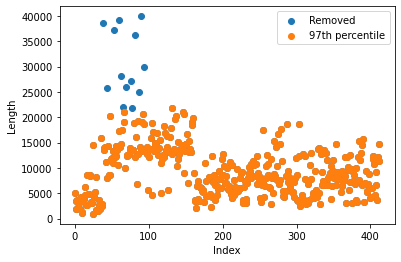

In [63]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
zebra_labels = df['label']
audio_size,audio_list_short,labels_short,_ = length_finder(audio_path,df,97)
zebra_labels = pd.Series(data=labels_short, index=[np.arange(len(labels_short))])
audio_files = pad(audio_list_short,audio_size)

train_val_images, TEST_images, train_val_y, TEST_y = train_test_split(audio_files, zebra_labels, test_size=0.25, random_state=42)
train_val_y.reset_index(drop=True, inplace=True) 

In [66]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
X = train_val_images
y = train_val_y
# Human Optimisation...
check_class_complete(kfold,X,y)
#optimised_params['learning_rate'] = 0.0014280245429123698/2
optimised_params['n_epochs'] = 25
n_epochs = optimised_params['n_epochs']
fold_loss = np.zeros((n_folds,n_epochs))
np.save('optimised_params',optimised_params)
print(optimised_params)

FOLD 3: Class missing from fold validation data.
ALL CLASSES PRESENT
{'learning_rate': 0.0008351125917121206, 'filters_1': 30, 'kernel_size_1': 8, 'activation_1': 'relu', 'pool_size_1': 2, 'filters_2': 26, 'kernel_size_2': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.4041500318305392, 'lin_1_n': 94, 'n_epochs': 25}


In [67]:
fold_no = 1
for train_index, test_index in kfold.split(X, y):
    
    print("-----------------------------------")
    print("FOLD "+str(fold_no))
    print("-----------------------------------")
    
    
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    balanced, balanced_labels = balancer(X_train,y_train)
    augmented_audio = augment_audio_faster_smaller(balanced)
    augmented_TEST = augment_audio_faster_smaller(X_test)
    
    mels = calc_melstft(augmented_audio)
    TEST_mels_inaug = calc_melstft_inaug(augmented_TEST[0])
    
    mels_norm_db = librosa.util.normalize(librosa.power_to_db(mels))
    TEST_mels_inaug_norm_db = librosa.util.normalize(librosa.power_to_db(TEST_mels_inaug))
    
    mels_1D = np.zeros(mels_norm_db[0].shape)
    mels_labels = balanced_labels
    mels_1D = mels_norm_db[0]
    print("Flattening")
    for i in range(1,mels_norm_db.shape[0]):
        mels_1D = np.concatenate((mels_1D,mels_norm_db[i]), axis = 0)
        mels_labels = np.concatenate((mels_labels,balanced_labels))
    
    
    X_train,X_val,y_train,y_val, img_rows, img_cols = format_for_CNN(mels_1D,TEST_mels_inaug_norm_db,mels_labels,y_test)
    
    model = opt_model(optimised_params)

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=n_epochs,
                        verbose=1,
                        validation_data=(X_val, y_val))
    
    fold_loss[fold_no-1] = history.history['val_categorical_accuracy']
    fold_no += 1

-----------------------------------
FOLD 1
-----------------------------------
Initial class proportions:
[0.604 0.046 0.096 0.254]
----------------------
Balancing: snort
Multiplier: 1.0
----------------------
Balancing: softsnort
Multiplier: 7.0
----------------------
Balancing: squeal
Multiplier: 2.0
----------------------
Balancing: whinnie
Multiplier: 1.0
----------------------
Final class proportions:
[0.441 0.234 0.14  0.185]
Augmenting 329 samples


100%|██████████| 329/329 [00:00<00:00, 928.09it/s]


Augmenting 60 samples


100%|██████████| 60/60 [00:00<00:00, 842.57it/s]


Augmentation  1 / 4


100%|██████████| 329/329 [00:01<00:00, 276.76it/s]


Augmentation  2 / 4


100%|██████████| 329/329 [00:01<00:00, 265.91it/s]


Augmentation  3 / 4


100%|██████████| 329/329 [00:01<00:00, 288.13it/s]


Augmentation  4 / 4


100%|██████████| 60/60 [00:00<00:00, 220.48it/s]


Flattening
Train on 1316 samples, validate on 60 samples
Epoch 1/25
1316/1316 [==============================] - 23s 18ms/sample - loss: 0.9892 - categorical_accuracy: 0.5631 - val_loss: 0.8150 - val_categorical_accuracy: 0.7167
Epoch 2/25
1316/1316 [==============================] - 23s 17ms/sample - loss: 0.6281 - categorical_accuracy: 0.7318 - val_loss: 0.5937 - val_categorical_accuracy: 0.7500
Epoch 3/25
1316/1316 [==============================] - 22s 17ms/sample - loss: 0.5275 - categorical_accuracy: 0.7622 - val_loss: 0.6042 - val_categorical_accuracy: 0.7833
Epoch 4/25
1316/1316 [==============================] - 22s 17ms/sample - loss: 0.4144 - categorical_accuracy: 0.8336 - val_loss: 0.5378 - val_categorical_accuracy: 0.7833
Epoch 5/25
1316/1316 [==============================] - 22s 17ms/sample - loss: 0.3370 - categorical_accuracy: 0.8655 - val_loss: 0.6253 - val_categorical_accuracy: 0.6833
Epoch 6/25
1316/1316 [==============================] - 22s 17ms/sample - loss: 0.3

100%|██████████| 347/347 [00:00<00:00, 675.94it/s]


Augmenting 60 samples


100%|██████████| 60/60 [00:00<00:00, 805.02it/s]


Augmentation  1 / 4


100%|██████████| 347/347 [00:01<00:00, 240.69it/s]


Augmentation  2 / 4


100%|██████████| 347/347 [00:01<00:00, 203.96it/s]


Augmentation  3 / 4


100%|██████████| 347/347 [00:01<00:00, 213.51it/s]


Augmentation  4 / 4


100%|██████████| 60/60 [00:00<00:00, 247.17it/s]


Flattening
Train on 1388 samples, validate on 60 samples
Epoch 1/25
1388/1388 [==============================] - 27s 19ms/sample - loss: 0.9825 - categorical_accuracy: 0.5821 - val_loss: 1.3687 - val_categorical_accuracy: 0.4667
Epoch 2/25
1388/1388 [==============================] - 29s 21ms/sample - loss: 0.5375 - categorical_accuracy: 0.7911 - val_loss: 0.9088 - val_categorical_accuracy: 0.6167
Epoch 3/25
1388/1388 [==============================] - 33s 24ms/sample - loss: 0.3563 - categorical_accuracy: 0.8581 - val_loss: 0.7355 - val_categorical_accuracy: 0.7333
Epoch 4/25
1388/1388 [==============================] - 27s 19ms/sample - loss: 0.2558 - categorical_accuracy: 0.9078 - val_loss: 0.5780 - val_categorical_accuracy: 0.8333
Epoch 5/25
1388/1388 [==============================] - 24s 17ms/sample - loss: 0.2045 - categorical_accuracy: 0.9222 - val_loss: 0.5551 - val_categorical_accuracy: 0.7833
Epoch 6/25
1388/1388 [==============================] - 24s 18ms/sample - loss: 0.1

100%|██████████| 344/344 [00:00<00:00, 906.88it/s]


Augmenting 60 samples


100%|██████████| 60/60 [00:00<00:00, 802.17it/s]


Augmentation  1 / 4


100%|██████████| 344/344 [00:01<00:00, 204.24it/s]


Augmentation  2 / 4


100%|██████████| 344/344 [00:01<00:00, 205.44it/s]


Augmentation  3 / 4


100%|██████████| 344/344 [00:01<00:00, 241.19it/s]


Augmentation  4 / 4


100%|██████████| 60/60 [00:00<00:00, 222.98it/s]


Flattening
Train on 1376 samples, validate on 60 samples
Epoch 1/25
1376/1376 [==============================] - 26s 19ms/sample - loss: 1.1545 - categorical_accuracy: 0.4746 - val_loss: 0.8524 - val_categorical_accuracy: 0.8500
Epoch 2/25
1376/1376 [==============================] - 24s 18ms/sample - loss: 0.7219 - categorical_accuracy: 0.6802 - val_loss: 0.7003 - val_categorical_accuracy: 0.6667
Epoch 3/25
1376/1376 [==============================] - 24s 17ms/sample - loss: 0.5782 - categorical_accuracy: 0.7435 - val_loss: 0.5940 - val_categorical_accuracy: 0.7833
Epoch 4/25
1376/1376 [==============================] - 24s 17ms/sample - loss: 0.4669 - categorical_accuracy: 0.7958 - val_loss: 0.5624 - val_categorical_accuracy: 0.7333
Epoch 5/25
1376/1376 [==============================] - 25s 18ms/sample - loss: 0.3883 - categorical_accuracy: 0.8314 - val_loss: 0.6226 - val_categorical_accuracy: 0.6833
Epoch 6/25
1376/1376 [==============================] - 24s 18ms/sample - loss: 0.3

100%|██████████| 334/334 [00:00<00:00, 1007.61it/s]


Augmenting 60 samples


100%|██████████| 60/60 [00:00<00:00, 778.45it/s]


Augmentation  1 / 4


100%|██████████| 334/334 [00:01<00:00, 277.36it/s]


Augmentation  2 / 4


100%|██████████| 334/334 [00:01<00:00, 247.39it/s]


Augmentation  3 / 4


100%|██████████| 334/334 [00:01<00:00, 231.35it/s]


Augmentation  4 / 4


100%|██████████| 60/60 [00:00<00:00, 166.66it/s]


Flattening
Train on 1336 samples, validate on 60 samples
Epoch 1/25
1336/1336 [==============================] - 25s 18ms/sample - loss: 1.1506 - categorical_accuracy: 0.4963 - val_loss: 1.0848 - val_categorical_accuracy: 0.4667
Epoch 2/25
1336/1336 [==============================] - 23s 17ms/sample - loss: 0.7483 - categorical_accuracy: 0.6737 - val_loss: 0.8615 - val_categorical_accuracy: 0.7000
Epoch 3/25
1336/1336 [==============================] - 23s 17ms/sample - loss: 0.5999 - categorical_accuracy: 0.7515 - val_loss: 0.8910 - val_categorical_accuracy: 0.6000
Epoch 4/25
1336/1336 [==============================] - 35s 26ms/sample - loss: 0.4921 - categorical_accuracy: 0.7994 - val_loss: 0.7090 - val_categorical_accuracy: 0.7000
Epoch 5/25
1336/1336 [==============================] - 48s 36ms/sample - loss: 0.3986 - categorical_accuracy: 0.8533 - val_loss: 0.5380 - val_categorical_accuracy: 0.7833
Epoch 6/25
1336/1336 [==============================] - 43s 32ms/sample - loss: 0.3

100%|██████████| 346/346 [00:00<00:00, 938.27it/s]


Augmenting 60 samples


100%|██████████| 60/60 [00:00<00:00, 849.91it/s]


Augmentation  1 / 4


100%|██████████| 346/346 [00:01<00:00, 293.41it/s]


Augmentation  2 / 4


100%|██████████| 346/346 [00:01<00:00, 282.45it/s]


Augmentation  3 / 4


100%|██████████| 346/346 [00:01<00:00, 250.94it/s]


Augmentation  4 / 4


100%|██████████| 60/60 [00:00<00:00, 267.40it/s]


Flattening
Train on 1384 samples, validate on 60 samples
Epoch 1/25
1384/1384 [==============================] - 25s 18ms/sample - loss: 1.0520 - categorical_accuracy: 0.5181 - val_loss: 1.0416 - val_categorical_accuracy: 0.4667
Epoch 2/25
1384/1384 [==============================] - 23s 17ms/sample - loss: 0.6377 - categorical_accuracy: 0.7233 - val_loss: 0.7058 - val_categorical_accuracy: 0.6500
Epoch 3/25
1384/1384 [==============================] - 22s 16ms/sample - loss: 0.5084 - categorical_accuracy: 0.7832 - val_loss: 0.6118 - val_categorical_accuracy: 0.6833
Epoch 4/25
1384/1384 [==============================] - 23s 17ms/sample - loss: 0.4573 - categorical_accuracy: 0.8114 - val_loss: 0.6576 - val_categorical_accuracy: 0.7000
Epoch 5/25
1384/1384 [==============================] - 23s 16ms/sample - loss: 0.4106 - categorical_accuracy: 0.8288 - val_loss: 0.5048 - val_categorical_accuracy: 0.8000
Epoch 6/25
1384/1384 [==============================] - 23s 16ms/sample - loss: 0.3

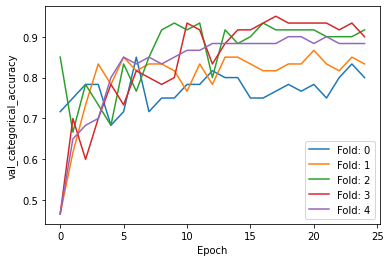

Mean val_categorical_accuracy:  0.86667


In [68]:
for i in range(n_folds):
    plt.plot(fold_loss[i], label='Fold: '+str(i))
plt.xlabel('Epoch')
plt.ylabel('val_categorical_accuracy')
plt.legend()
plt.show()
mean_acc = np.mean(fold_loss[:,-1])
print('Mean val_categorical_accuracy: ',np.around(mean_acc,5))

1st convolution layer:


IndexError: index 30 is out of bounds for axis 3 with size 30

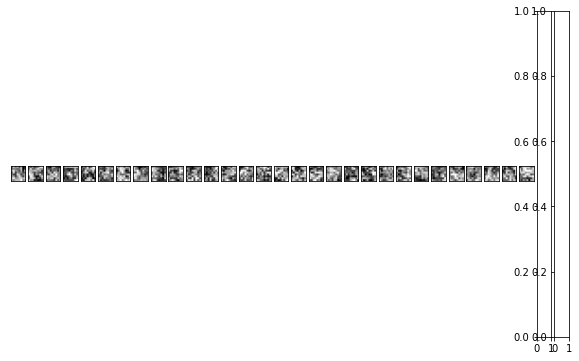

In [69]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

n_1 = 32
print('1st convolution layer:')
fig, axs = plt.subplots(1,n_1, figsize=(10, 6))
axs = axs.ravel()
for i in range(n_1):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

n_2 = 62
print('2nd convolution layer:')
fig, axs = plt.subplots(1,n_2, figsize=(10, 6))
axs = axs.ravel()
for i in range(n_2):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

In [70]:
def format_for_CNN_TEST_INAUG(X_test,y_test):

    # Standardize pixel distribution to have zero mean and unit variance
    test_images = standardizeimg(img=X_test, mu=np.mean(X_test), sigma=np.std(X_test))

    # adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
    img_rows, img_cols = X_test.shape[1], X_test.shape[2] # input image dimensions
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

    # convert class vectors to binary class matrices - one hot encoding
    onehot_v = pd.get_dummies(y_test)
    y_test = onehot_v.to_numpy()
    
    return X_test,y_test,img_rows,img_cols

In [71]:
TEST_CNN,TEST_CNN_y, _, _ = format_for_CNN_TEST_INAUG(test_images, test_y)
print(TEST_CNN.shape)
print(TEST_CNN_y.shape)

(100, 128, 51, 1)
(100, 4)


In [72]:
predicted_prob = model.predict(TEST_CNN)
predictions = np.argmax(predicted_prob, axis=1)

In [73]:
print(predictions.shape)
print(TEST_CNN_y.shape)

(100,)
(100, 4)


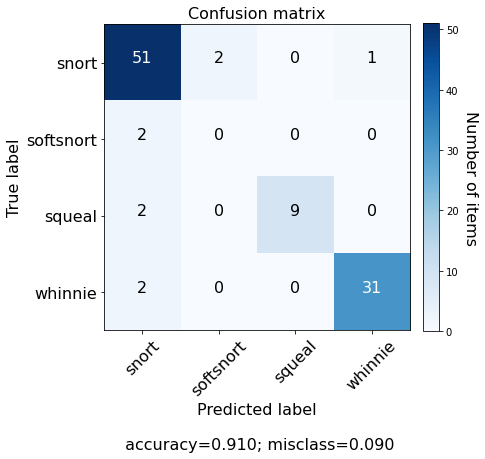

In [74]:
labels_list = np.unique(TEST_y)
onehot_y = TEST_CNN_y
truths = np.argmax(onehot_y, axis=1)
cm = confusion_matrix(truths, predictions, labels=range(num_classes))
plot_confusion_matrix(cm,labels_list,normalize=False,savefig = 'CM_CNN_OPT_INAUG_TEST')